**Implementing Logistic Regression from scratch**

Dataset: https://www.kaggle.com/dragonheir/logistic-regression

The goal is to check if a user would click on an advertisement based on his gender, age and salary.

Code by: Vishal Kundar

In [164]:
#Importing necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [165]:
#Reading dataset
data = pd.read_csv('Social_Network_Ads.csv')
data.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [166]:
#Checking for missing data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


There seems to be no data missing

In [167]:
#Properties of data
data.describe()

,User ID,Age,EstimatedSalary,Purchased
count,4.000000e+02,400.000000,400.000000,400.000000
mean,1.569154e+07,37.655000,69742.500000,0.357500
std,7.165832e+04,10.482877,34096.960282,0.479864
min,1.556669e+07,18.000000,15000.000000,0.000000
25%,1.562676e+07,29.750000,43000.000000,0.000000
50%,1.569434e+07,37.000000,70000.000000,0.000000
75%,1.575036e+07,46.000000,88000.000000,1.000000
max,1.581524e+07,60.000000,150000.000000,1.000000


Before moving on further let us encode the categorical variable - gender

In [168]:
#Using label encoder to encode the categorical feature - Gender
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

data['Gender'] = le.fit_transform(data['Gender'])
data.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,1,19,19000,0
1,15810944,1,35,20000,0
2,15668575,0,26,43000,0
3,15603246,0,27,57000,0
4,15804002,1,19,76000,0


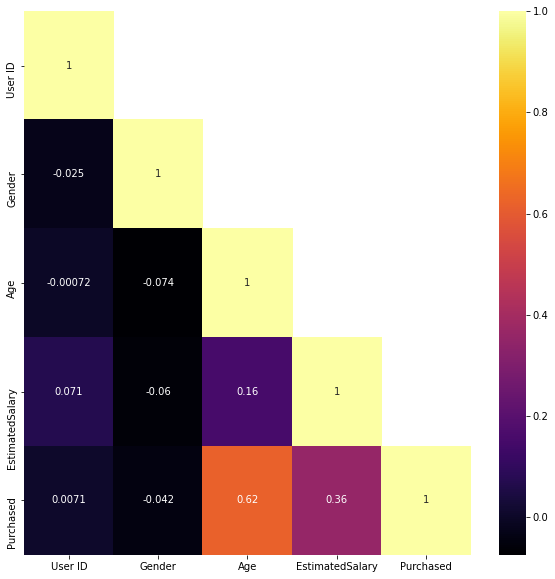

In [169]:
#Plotting heatmap of correlation matrix of features
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(),annot=True,cmap='inferno',mask=np.triu(data.corr(),k=1))

As there is little to no relation of userID and gender w.r.t the dependent feature - Purchased, we will drop it.

In [170]:
#Replacing space in column headers with '_'
data.columns = data.columns.str.replace(' ', '_')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   User_ID          400 non-null    int64
 1   Gender           400 non-null    int64
 2   Age              400 non-null    int64
 3   EstimatedSalary  400 non-null    int64
 4   Purchased        400 non-null    int64
dtypes: int64(5)
memory usage: 15.8 KB


In [171]:
#Dropping user_id and gender
data.drop(labels = ['User_ID','Gender'], axis = 1, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Age              400 non-null    int64
 1   EstimatedSalary  400 non-null    int64
 2   Purchased        400 non-null    int64
dtypes: int64(3)
memory usage: 9.5 KB


In [172]:
#checking for duplicates
sum(data.duplicated())

33

These are the duplicate data present. We will delete them

In [173]:
#dropping ALL duplicate values
data.drop_duplicates(keep = False, inplace = True)

Let us find outliers

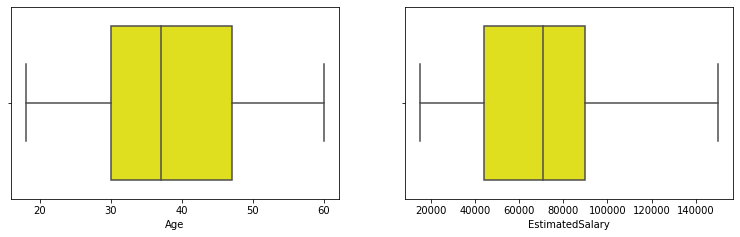

In [174]:
#Plotting boxplot of features to find outliers
plt.figure(figsize=(20, 12))

plt.subplot(3,3,1)
sns.boxplot(data['Age'],color='yellow')
plt.subplot(3,3,2)
sns.boxplot(data['EstimatedSalary'], color='yellow')

plt.show()

There seems to be no outliers present

Text(0.5, 1.0, 'Class Distributions')

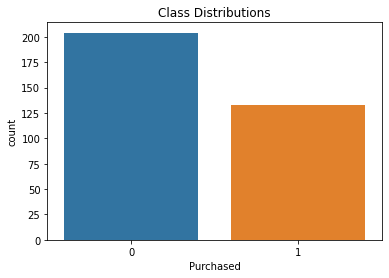

In [175]:
#Viewing class distribution
plt.figure(figsize=(6, 4))
sns.countplot('Purchased', data=data)
plt.title('Class Distributions')

The data is not too imbalanced so no need of resampling.

#**Model Training**

In [176]:
#Getting X and y
X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

In [177]:
#Splitting data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

#reshaping
y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(269, 2) (269,) (68, 2) (68,)
(269, 2) (269, 1) (68, 2) (68, 1)


Scaling data

In [178]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [179]:
#adding bias variable
X_new = np.concatenate((np.ones((len(X_train), 1), dtype = int), X_train), axis = 1)
print(X_new.shape)

(269, 3)


In [90]:
#Sigmoid activation function
def sigmoid_function(X, theta):
    """
    Arguments: 
      X - Feature matrix X also containing the bias variable
      theta - parameters being optimized

    Returns:
      h - hypothesis function 1 / (1 + e ^-(X * theta))
    """

    h = (1 / (1 + np.exp(-np.matmul(X, theta))))
    return h

In [79]:
#Computing cost
def cost_function(m, h, y):
    """
    Arguments: 
      m - size of training set
      h - hypothesis function (X * theta)
      y - dependent variable

    Returns:
      J - Computed cost    
    """
    
    J = (np.sum((-y * np.log(h)) - ((1 - y) * (np.log(1 - h)))) / m)
    return J

In [55]:
#gradient descent
def grad_func(m, X, y, theta, alpha, h):
    """
    Arguments: 
      m - size of training set
      X - Feature matrix X also containing the bias variable
      y - dependent variable
      theta - parameters being optimized
      alpha - learning rate 
      h - hypothesis function (X * theta)

    Returns:
      theta - Optimized parameters    
    """

    theta = theta - ((alpha/m) * (np.matmul((h - y).T, X))).T
    return theta

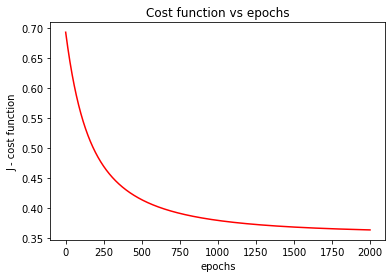

In [180]:
#Logistic Regression from scratch
m = len(X_new)
alpha = 0.01403 #Obatined by trial and error
cost = []
epochs = 2000

#theta initialization
theta = np.zeros((X_new.shape[1], 1),dtype=float)

for i in range(epochs):
  h = sigmoid_function(X_new, theta)
  J = cost_function(m, h, y_train)
  cost.append(J)
  theta = grad_func(m, X_new, y_train, theta, alpha, h)

#Plotting cost function vs epochs
plt.plot(list(range(epochs)), cost, '-r')
plt.title("Cost function vs epochs")
plt.xlabel("epochs")
plt.ylabel("J - cost function")
plt.show()

In [181]:
#Preparing test data

#adding bias variable
Xt_new = np.concatenate((np.ones((len(X_test), 1), dtype=int), X_test), axis=1)
print(Xt_new.shape, y_test.shape)

(68, 3) (68, 1)


In [182]:
#Predicting results
y_pred = sigmoid_function(Xt_new, theta)
print(y_pred.shape)

y_pred_new = []
for x in y_pred:
    y_pred_new.append(1 if(x > 0.5) else 0)

y_pred_new = np.array(y_pred_new)
y_pred_new = y_pred_new.T
y_pred_new = y_pred_new.reshape(len(y_pred_new), 1)

print(y_pred_new.shape)

(68, 1)
(68, 1)


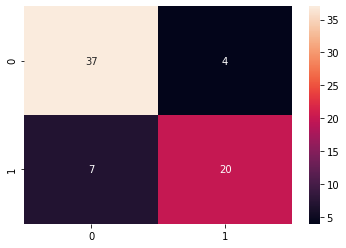

In [183]:
#Confusion matrix visualized:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred_new)

sns.heatmap(cf_matrix, annot=True)

In [184]:
#Metrics based result
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        41
           1       0.83      0.74      0.78        27

    accuracy                           0.84        68
   macro avg       0.84      0.82      0.83        68
weighted avg       0.84      0.84      0.84        68



**Thank you!** -@Vishal_Kundar